# Full inference for 2D section

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import json
import poly
import utils

import torch
from torchvision import transforms

from classifiers import ClfNet

# das hier ist Mist! Vorher in 2D Koordinaten transformieren...
import sys
sys.path.append("../2dshape")
import mg

## Convert 3D coordinates to 2D

In [43]:
basedir = "../2dshape/data_baseline/"
infiles = ["circ_sections.json", "long_sections.json"]

secs = {}
for fname in infiles:
    with open(os.path.join(basedir, fname)) as fp:
        secs.update(json.load(fp))


In [44]:
print(len(secs))

120


## Make Image

In [45]:
section = secs['240'][101]
uvo, uvi = mg.section_xyz_to_uv(section['outer'], section['inner'], section['tmat'])

True area: 114.221


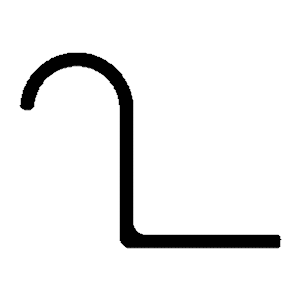

In [46]:
a_true = poly.polygon_area(uvo, uvi)
print("True area: %.3f" % a_true)
img = utils.image_cv2(uvo, uvi)
img = Image.fromarray(img)
img

## Classify

In [47]:
fpath_classifier = "models/classifier2.pt"
classifier = ClfNet.from_checkpoint(fpath_classifier)
classifier.eval()
# TODO: store this somewhere
CLASS_NAMES = ['C2', 'I1', 'L2', 'OTHER', 'Z3', 'Z5', 'Z8', 'Z9']


Input size: 224, output size: 8
parameter names: 


In [48]:
# transformation
xfo = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

def predict_probas(model, img):
    """run model on a PIL image, return class probas"""
    inp = xfo(img)
    inp = inp.expand((1,) + inp.shape) # because it's just one image -> TODO: use unsqueeze()
    with torch.no_grad():
        logits = model(inp).detach()
    return logits.exp().squeeze().numpy()

In [49]:
p = predict_probas(classifier, img)
df = pd.DataFrame({'p': p, 'cls': CLASS_NAMES})
df

,p,cls
0,2.054489e-09,C2
1,3.249017e-15,I1
2,5.956759e-08,L2
3,3.035245e-04,OTHER
4,2.571924e-08,Z3
5,1.181193e-08,Z5
6,9.971703e-01,Z8
7,2.526122e-03,Z9


In [50]:
predicted_class = CLASS_NAMES[np.argmax(p)]
print(predicted_class)

Z8


## Regression

In [51]:
regression_class = predicted_class
#regression_class = "Z3"

In [52]:
from regression import Net1, no_transform
import pickle

regressor = Net1.from_checkpoint("models/%s_flip_50.pt" % regression_class)
regressor.eval()
with open("dataset/%s_scaler.pkl" % regression_class, "rb") as fp:
    scaler = pickle.load(fp)

Z8
Input size: 150, output size: 6
parameter names: h, tw, ba, ta, ra, rf


In [53]:
xfo_r = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(150),
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
    ])

def estimate_params(image, model, scaler):
    """run model on a PIL image, return parameters (scaled to unit area)"""
    inp = xfo_r(image)
    inp = inp.expand((1,) + inp.shape) 
    with torch.no_grad():
        outputs = model(inp).numpy()
    return scaler.inverse_transform(outputs).squeeze()

In [54]:
estim = estimate_params(img, regressor, scaler)
estimated_params = np.sqrt(a_true)*estim
print(estimated_params)

[30.912346   1.6647856 18.310469   1.7246717  2.2045984  9.1412945]


## Compare NN output to Thruth

In [55]:
import sections

In [56]:
pred = sections.section(regression_class.lower(), *estimated_params)
pt = general_section(uvo, uvi)

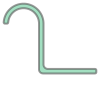

In [57]:
pt

In [58]:
pt.bounds

(-16.0715170292312, 0.2990754882207485, 21.109297231115466, 28.29983459390212)

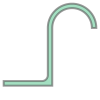

In [59]:
pred

## Fine Tuning

In [60]:
import shapely
from shapely.geometry import Polygon
from shapely import speedups

from scipy.optimize import differential_evolution, basinhopping, shgo, dual_annealing
from sections import section, VERTEX_FUNCTIONS

In [61]:
def cost(x, p0, section_type):
    # first element of x: theta
    theta = x[0]
    # rest: shape parameters
    try:
        poly = section(section_type, *x)
        #poly = shapely.affinity.rotate(poly, theta, use_radians=True)
        poly = shapely.affinity.translate(poly, -poly.centroid.x, -poly.centroid.y)
        diff = p0.symmetric_difference(poly)
        return diff.area/p0.area
    except:
        return 2.0 # FIXME: this is an arbitrary value - anything better?

    
def general_section(outers, inners):
    "Return a shapely polygon"
    p = Polygon(outers[0])
    for verts in outers[1:]:
        p = p.union(Polygon(verts))
    for verts in inners:
        p = p.difference(Polygon(verts))
    #assert p.is_valid
    return p if p.is_valid else None

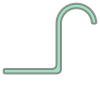

In [62]:
# true section
mirror = True

pt = general_section(uvo, uvi)
pt = shapely.affinity.translate(pt, -pt.centroid.x, -pt.centroid.y)

if mirror:
    pt = shapely.affinity.affine_transform(pt, [-1, 0, 0, 1, 0, 0])
    
pt

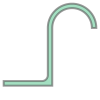

In [63]:
# predicted section

sectype = regression_class.lower()
xp = estimated_params
pp = section(sectype, *xp)
# move centroid to origin
pp = shapely.affinity.translate(pp, -pp.centroid.x, -pp.centroid.y)
pp

In [64]:
vfunc, param_names = sections.VERTEX_FUNCTIONS[predicted_class.lower()]
dict(zip(param_names, estimated_params))

{'h': 30.912346,
 'tw': 1.6647856,
 'ba': 18.310469,
 'ta': 1.7246717,
 'ra': 2.2045984,
 'rf': 9.1412945}

In [65]:
# bounds: +/- 10% of prediction ?
# Not a good estimate - especially for the radii.

In [66]:
search_width = 0.3
bounds = []
for key, value in zip(param_names, estimated_params):
    if key.startswith("r"):
        bounds.append((1, 12))
    else: 
        bounds.append(((1-search_width)*value, (1+search_width)*value))

# works
result = differential_evolution(cost, bounds, tol=0.001, maxiter=1000,
                                args=(pt, sectype), strategy='best1bin')
#result = dual_annealing(cost, bounds, args=(pt, sectype), x0=estimated_params)

In [67]:
result

     fun: 0.015363975260139872
     jac: array([ 0.00011683, -0.00083906,  0.00010718,  0.00055029,  0.00311861,
        0.00022018])
 message: 'Optimization terminated successfully.'
    nfev: 12955
     nit: 141
 success: True
       x: array([27.98794612,  1.8007236 , 23.09640753,  1.78560199,  1.        ,
        8.00021076])

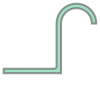

In [68]:
px = section(sectype, *result.x)
px = shapely.affinity.translate(px, -px.centroid.x, -px.centroid.y)
px

In [69]:
# IoU
pt.intersection(px).area / pt.union(px).area

0.9847643877216634

In [70]:
pt.area, px.area

(114.22106047124889, 114.39084000047222)

In [41]:
dict(zip(param_names, result.x))

{'h': 27.987941358739494,
 'tw': 1.8007241812408714,
 'ba': 23.096446997727387,
 'ta': 1.785598493726941,
 'ra': 1.0,
 'rf': 8.000213500070569}